In [1]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from extract_graph import dic_to_sparse, from_sparse_to_graph, generate_nx_graph, prune_graph, from_nx_to_tab, from_nx_to_tab_matlab,sparse_to_doc, connections_pixel_list_to_tab, transform_list, clean_degree_4
from time import sleep

In [1]:
for j in range(0,12):
    my_file = open("/scratch/shared/mrozemul/Fiji.app/python/test_job.sh", "w")
    my_file.write("#!/bin/bash \n#Set job requirements \n#SBATCH -N 1 \n#SBATCH -t 2:00:00\n#SBATCH -p normal\n")
    my_file.write(f'for i in `seq {4*j} {4*j+3}`; do\n')
    my_file.write("\t python extract_skel_surf.py $i &\n")
    my_file.write('done\n')
    my_file.write('wait\n')
    my_file.close()
#     !srun -t 2:00:00 --pty ../test_job.sh
    !sbatch ../test_job.sh

Submitted batch job 9353734
Submitted batch job 9353735
Submitted batch job 9353736
Submitted batch job 9353737
Submitted batch job 9353738
Submitted batch job 9353739
Submitted batch job 9353740
Submitted batch job 9353741
Submitted batch job 9353742
Submitted batch job 9353743
Submitted batch job 9353744
Submitted batch job 9353746


In [4]:
plate = 9
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']

In [5]:
len(list_dir_interest)

48

In [39]:
plate = 9
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime[8:10]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
dilateds=[]
skels = []
skel_docs = []
graph_pos=[]
for date in dates:
    directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
    path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
    dilated = read_mat(path_snap+'/Analysis/dilated.mat')['dilated']
    skel = read_mat(path_snap+'/Analysis/skeleton.mat')['skeleton']
    dilateds.append(dilated)
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
    nx_graph,pos = generate_nx_graph(from_sparse_to_graph(skel_doc))
    graph_pos.append((nx_graph,pos))
    S = [nw_graph.subgraph(c).copy() for c in nx.connected_components(nw_graph)]
    selected = [g for g in S if g.size(weight="weight")*len(g.nodes)/10**6>=100]
    len_connected=[(nx_graph.size(weight="weight"),len(nx_graph.nodes)) for nx_graph in S]
    print(len_connected)

[(127.0, 2), (188.0, 2), (13.0, 2), (71.0, 2), (24.0, 2), (6.0, 2), (1799.0, 26), (219.0, 8), (278.0, 2), (120.0, 4), (94.0, 2), (19.0, 2), (67.0, 2), (13113.0, 36), (29.0, 2), (25.0, 2), (542.0, 2), (576617.0, 6593), (21.0, 2), (55.0, 2), (33.0, 4), (18.0, 2), (2.0, 2), (34.0, 4), (3.0, 2), (51.0, 2), (31.0, 2), (28.0, 2), (54.0, 2), (395.0, 4), (445.0, 2), (248.0, 8), (19.0, 2), (26.0, 2), (100.0, 2), (108.0, 6), (109.0, 4), (124.0, 4), (234.0, 12), (250.0, 4), (195.0, 4), (9.0, 2), (624.0, 10), (1228.0, 28), (18172.0, 96), (94.0, 2), (3438.0, 2)]
[(127.0, 2), (188.0, 2), (13.0, 2), (71.0, 2), (24.0, 2), (6.0, 2), (1799.0, 26), (219.0, 8), (278.0, 2), (120.0, 4), (94.0, 2), (19.0, 2), (67.0, 2), (13113.0, 36), (29.0, 2), (25.0, 2), (542.0, 2), (576617.0, 6593), (21.0, 2), (55.0, 2), (33.0, 4), (18.0, 2), (2.0, 2), (34.0, 4), (3.0, 2), (51.0, 2), (31.0, 2), (28.0, 2), (54.0, 2), (395.0, 4), (445.0, 2), (248.0, 8), (19.0, 2), (26.0, 2), (100.0, 2), (108.0, 6), (109.0, 4), (124.0, 4), (

In [13]:
for 
skel_doc = sparse_to_doc(skel)
nw_graph,pos = generate_nx_graph(from_sparse_to_graph(skel_doc))


In [14]:
S = [nw_graph.subgraph(c).copy() for c in nx.connected_components(nw_graph)]
selected = [g for g in S if g.size(weight="weight")*len(g.nodes)/10**6>=100]
len_connected=[(nx_graph.size(weight="weight"),len(nx_graph.nodes)) for nx_graph in S]
print(len_connected)

[(127.0, 2), (188.0, 2), (13.0, 2), (71.0, 2), (24.0, 2), (6.0, 2), (1799.0, 26), (219.0, 8), (278.0, 2), (120.0, 4), (94.0, 2), (19.0, 2), (67.0, 2), (13113.0, 36), (29.0, 2), (25.0, 2), (542.0, 2), (576617.0, 6593), (21.0, 2), (55.0, 2), (33.0, 4), (18.0, 2), (2.0, 2), (34.0, 4), (3.0, 2), (51.0, 2), (31.0, 2), (28.0, 2), (54.0, 2), (395.0, 4), (445.0, 2), (248.0, 8), (19.0, 2), (26.0, 2), (100.0, 2), (108.0, 6), (109.0, 4), (124.0, 4), (234.0, 12), (250.0, 4), (195.0, 4), (9.0, 2), (624.0, 10), (1228.0, 28), (18172.0, 96), (94.0, 2), (3438.0, 2)]


In [17]:
pos[choice(list(selected[0].nodes))]

array([20070, 43201])

In [40]:
plot_t_tp1([],[],None,None,skels[0][18000:22000,43000:47000],skels[1][18000:22000,43000:47000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
fig=plt.figure(figsize=(14,11))
ax = fig.add_subplot(111)
ax.imshow(skel[18000:22000,43000:47000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
path_tile=path_snap+'/Img/TileConfiguration.txt.registered'
tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
dirName = path_snap+'/Analysis'
shape = (3000,4096)
try:
    os.mkdir(path_snap+'/Analysis') 
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
#     print(name.split('/')[-1])
    ims.append(imageio.imread(path_snap+'/Img/'+name.split('/')[-1]))

Directory  /scratch/shared/mrozemul/Fiji.app/20200724_0821_Plate09/Analysis  already exists


In [40]:
im = choice(ims)

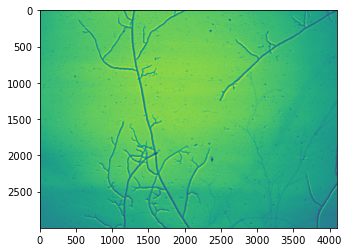

In [41]:
plt.imshow(im)

In [43]:
from skimage.feature import hessian_matrix_det
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)*120
# # im_back_rem = im_cropped*1.0
# # # im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
frangised = frangi(im_back_rem,sigmas=range(1,20,4))*255
# # frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
hessian = hessian_matrix_det(im_back_rem,sigma = 20)
transformed = (frangised+cv2.normalize(abs(hessian), None, 0, 255, cv2.NORM_MINMAX)-im_back_rem+120)*(im_blurred>=35)
low = 20
high = 300
lowt = (transformed > low).astype(int)
hight = (transformed > high).astype(int)
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
for i in range(3):
    dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
dilated = dilation>0

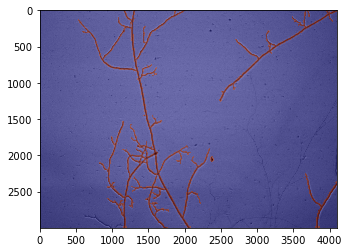

In [45]:
from plotutil import overlap

overlap(dilated,im)

In [46]:
skeletonized = cv2.ximgproc.thinning(np.array(255*(dilated>0),dtype=np.uint8))

In [52]:
np.sum(skeletonized)/255

25429.0

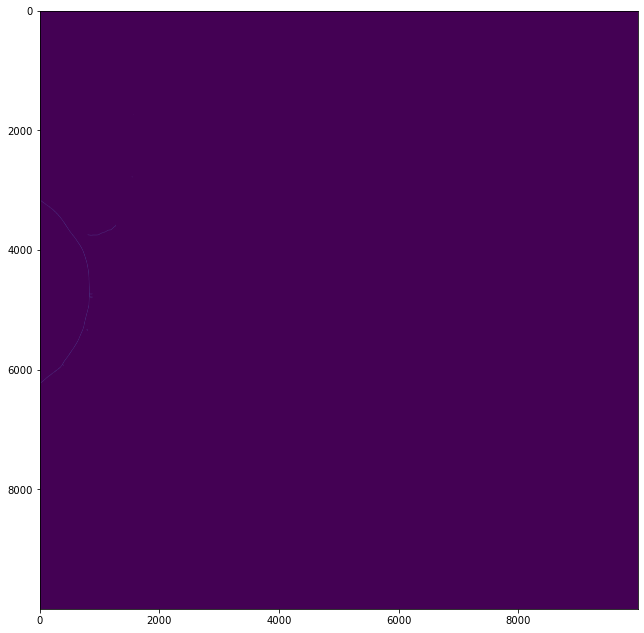

In [62]:
fig=plt.figure(figsize=(14,11))
ax = fig.add_subplot(111)
ax.imshow(skel[10000:20000,10000:20000])

In [2]:

import os

# pathlib.Path().absolute()
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 

In [3]:
plate = 9
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']

In [8]:
list_dir_interest[2]

'20200715_2334_Plate09'

In [8]:
date = '0714_1534'
date_plate = f'/2020{date}'
plate = 9
plate_str = f'_Plate0{plate}'
path_snap='../..'+date_plate+plate_str
path_tile=path_snap+'/Img/TileConfiguration.txt.registered'
tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
os.mkdir(path_snap+'/Analysis')

FileExistsError: [Errno 17] File exists: '../../20200714_1534_Plate09/Analysis'

In [41]:
listdir=os.listdir(path_snap) 

In [ ]:
list

In [7]:
from time import time,sleep
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(imageio.imread(f'{name}'))
# skel = np.zeros(dim,dtype=np.uint8)

NameError: name 'tileconfig' is not defined

In [20]:
def frangising():
    im  = choice(ims)
#     im_cropped = im
#     im_blurred =cv2.blur(im_cropped, (200, 200))
#     im_back_rem = (im_cropped+1)/(im_blurred+1)
#     im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
#     im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    frangised = frangi(im,sigmas=range(10,40,3))

In [ ]:
import cProfile
cProfile.run('frangising()')

In [21]:
dim = 26481,49456
skel = np.zeros(dim,dtype=np.uint8)
skelsp = scipy.sparse.lil_matrix((dim))

In [28]:
skelsp[5,1]+=1

In [29]:
skelsp

<26481x49456 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in List of Lists format>

In [32]:
len(skelsp.nonzero()[0])

2

In [22]:
import sys
sys.getsizeof(skelsp)/10**6

6.4e-05

In [ ]:
from time import time,sleep
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(imageio.imread(f'{name}'))
skel = scipy.sparse.lil_matrix((dim))
for index,im in enumerate(ims):
    print(index)
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped+1)/(im_blurred+1)
    im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    frangised = frangi(im_back_rem,sigmas=range(1,20,4))
    frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
    transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    transformed = cv2.normalize(-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    low = 180
    high = 200
    lowt = (transformed > low).astype(int)
    hight = (transformed > high).astype(int)
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
    for i in range(3):
        dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilated = dilation>0
#     np.save(f'Temp\dilated{tileconfig[0][i]}',dilated)
    skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated
skeletonized = cv2.ximgproc.thinning(np.array(255*(skel>0),dtype=np.uint8))
sio.savemat(path_snap+'/Analysis/dilated.mat',{'dilated' : skel})
sio.savemat(path_snap+'/Analysis/skeleton.mat',{'skeleton' : skeletonized})
print('time=',time()-t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [1]:
skel

NameError: name 'skel' is not defined

In [24]:
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
import scipy.sparse
shape = (3000,4096)
skel = np.zeros(dim,dtype=np.uint8)
for index,im in enumerate(ims):
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped+1)/(im_blurred+1)
    im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
#     frangised = frangi(im_back_rem,sigmas=range(1,20,4))
#     frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    transformed = cv2.normalize(-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    low = 180
    high = 200
    lowt = (transformed > low).astype(int)
    hight = (transformed > high).astype(int)
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
    for i in range(3):
        dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilated = dilation>0
    sparse_dilated = scipy.sparse.csc_matrix(dilated)
#     np.save(f'Temp\dilated{tileconfig[0][i]}',dilated)
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
#     print(boundaries)
#     print(skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]].shape,sparse_dilated.shape)
    if np.mean(sparse_dilated)<=0.5:
        skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated
#     skeletonized = thin(dilated)
#     break

In [27]:
np.sum(skel>0),np.sum(skel<=0)

(7728880, 1295474584)

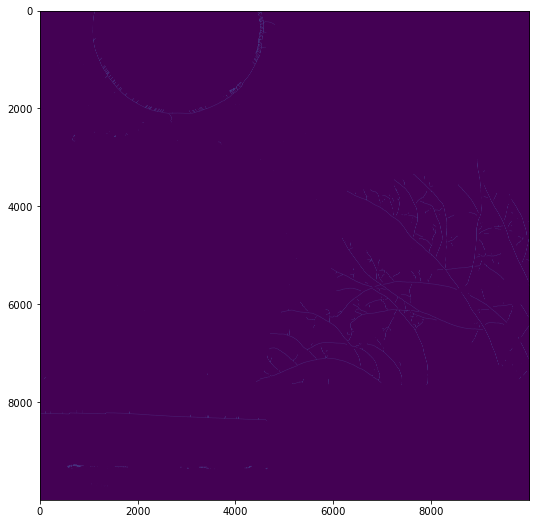

In [33]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(cv2.ximgproc.thinning(np.array(255*(skel[15000:25000,35000:45000]>0),dtype=np.uint8)))

In [34]:
cProfile.run('cv2.ximgproc.thinning(np.array(255*(skel[15000:25000,35000:45000]>0),dtype=np.uint8))')

NameError: name 'cProfile' is not defined

In [ ]:
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    im=np.load(f'Temp\{name}.npy')
    if np.mean(im)<=100:
        print(name)
#     ims.append(np.load(f'Temp\{name}.npy'))

In [ ]:
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    im=np.load(f'Temp\{name}.npy')
    if name == 'Img_r07_c12.tif':
        print(np.mean(im))
        plt.close('all')
        fig=plt.figure(figsize=(10,9))
        ax = fig.add_subplot(111)
        ax.imshow(im)
        imi = im

In [12]:
for index,im in enumerate(ims):
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped+1)/(im_blurred+1)
    im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
#     frangised = frangi(im_back_rem,sigmas=range(1,20,4))
#     frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    transformed = cv2.normalize(-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    low = 100
    high = 200
    lowt = (transformed > low).astype(int)
    hight = (transformed > high).astype(int)
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
    for i in range(3):
        dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilated = dilation>0
    sparse_dilated = scipy.sparse.csc_matrix(dilated)
#     np.save(f'Temp\dilated{tileconfig[0][i]}',dilated)
    np.save(f'Temp/sparse_matrix{tileconfig[0][index][:-4]}', sparse_dilated)
#     skeletonized = thin(dilated)
#     break

In [6]:
np.sum(skel>0),np.sum(skel<=0)

(13091473, 1296470273)

In [ ]:
skeletonized = cv2.ximgproc.thinning(np.array(255*(skel>0),dtype=np.uint8))

In [ ]:
import cProfile
cProfile.run('cv2.ximgproc.thinning(np.array(255*(skel>0),dtype=np.uint8))')

In [8]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skeletonized)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
tileconfig[0][3][:-4]

'Img_r01_c04'

In [5]:
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]

In [6]:
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)

In [35]:
skel = np.zeros(dim,dtype=np.uint8)

In [36]:
import sys
sys.getsizeof(skel)/(10**6)

1309.561858

In [38]:
shape = (3000,4096)
for index,im in enumerate(ims):
    sparse_dilated = scipy.sparse.load_npz(f'Temp/sparse_matrix{tileconfig[0][index][:-4]}.npz').todense()
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
#     print(boundaries)
#     print(skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]].shape,sparse_dilated.shape)
    skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated

In [7]:
skel = skel>0


NameError: name 'skel' is not defined

In [52]:
np.sum(skeletonized)

0

In [41]:
skel.dtype=np.uint8

In [27]:
sys.getsizeof(skel)/(10**6)

1309.561858

In [72]:
image = cv2.imread("OpenCV.png")
thinned = cv2.ximgproc.thinning(np.array(255-255*(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)>0),dtype=np.uint8))

In [73]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(thinned)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skeletonized[10000:20000,10000:20000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
img1 = skel.copy()
# Structuring Element
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
# Create an empty output image to hold values
thin = np.zeros(img1.shape,dtype='uint8') 
while (cv2.countNonZero(img1)!=0):
    # Erosion
    erode = cv2.erode(img1,kernel)
    # Opening on eroded image
    opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
    # Subtract these two
    subset = erode - opening
    # Union of all previous sets
    thin = cv2.bitwise_or(subset,thin)
    # Set the eroded image for next iteration
    img1 = erode.copy()

In [28]:
skeletonized = thin(skel)

KeyboardInterrupt: 

In [111]:
scipy.sparse.save_npz(f'Temp/sparse_matrix{tileconfig[0][i]}.npz', sparse_dilated)


In [56]:
values = [np.mean(im) for im in ims]

In [57]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.hist(values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([33.,  2.,  4.,  5.,  8.,  8., 10.,  7., 32., 41.]),
 array([  0.        ,  15.46855857,  30.93711714,  46.40567571,
         61.87423428,  77.34279285,  92.81135142, 108.27990999,
        123.74846855, 139.21702712, 154.68558569]),
 <BarContainer object of 10 artists>)

In [107]:
plt.close('all')
im = choice(ims)
print(np.mean(im))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im)

11.942084879557292


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)
im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
frangised = frangi(im_back_rem,sigmas=range(1,20,4))
frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
low = 100
high = 200
lowt = (transformed > low).astype(int)
hight = (transformed > high).astype(int)
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
for i in range(3):
    dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
dilated = dilation>0
skeletonized = thin(dilated)

In [108]:
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)
im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)

In [109]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im_back_rem)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skeletonized)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …